In [1]:
# 引入Python包，在jupyter notebook 运行后可以直接输出多个变量 注意大小写
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 指定gpu设备
import os
os.environ['CUDA_VISIBLE_DEVICES'] ="0" # gpu
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # cpu

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

In [2]:
import cv2

shape: (360, 270, 3)


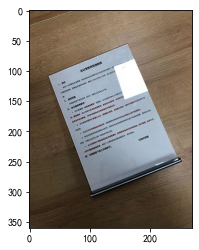

In [3]:
img = cv2.imread(r'../../dataset/transforms_test.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('shape: {}'.format(img.shape))
plt.imshow(img);

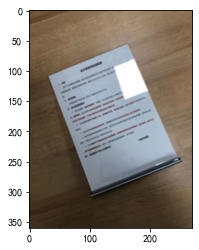

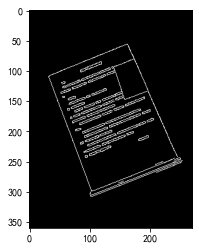

In [4]:
# 旋转
# 第一步，通过canny求出画纸的外边框，然后得到倾斜角度
# 图像平滑，去除不需要的边缘噪声
gauss_img = cv2.GaussianBlur(img, (3,3), 1)
plt.imshow(gauss_img)
plt.show()
edga_img = cv2.Canny(gauss_img, 30, 250)
plt.imshow(edga_img, cmap='gray')

-21.801406860351562 (205.7504425048828, 153.01295471191406) [[ 26 109]
 [168  52]
 [244 243]
 [102 300]]


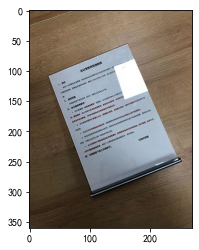

[[  0.92847671  -0.37139063  71.54352723]
 [  0.37139063   0.92847671 -65.46979699]]


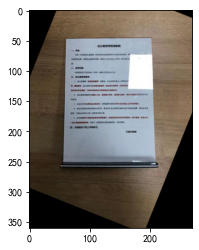

In [5]:

# 获取图像的倾斜角度和矩形框
# 求最大的那个框的位置
def get_angle(image):
    in_img = image.copy()
    angle = 0.0
    area = 0.0
    out_center = np.zeros(2)
    out_box = np.zeros(4)
    contours, hierarchy = cv2.findContours(in_img, 2, 2)
    for cnt in contours:
        # 最小外界矩形的宽度和高度
        # cv2.minAreaRect(cnt)
        width, height = cv2.minAreaRect(cnt)[1]

        if width * height > 100 and width * height > area:
            area = width * height
            # 最小的外接矩形
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)  # 获取最小外接矩形的4个顶点
            box = np.int0(box)

            if 0 not in box.ravel():
                # 绘制最小外界矩形
                # for i in range(4):
                #     cv2.line(in_img, tuple(box[i]), tuple(box[(i+1)%4]), 255, thickness=2)  # 5

                # 函数 cv2.minAreaRect() 返回一个Box2D结构 rect：（最小外接矩形的中心（x，y），（宽度，高度），旋转角度）。
                # 分别对应于返回值：(rect[0][0],  rect[0][1]),  (rect[1][0],  rect[1][1]),  rect[2]
                # 旋转角度
                rect = cv2.minAreaRect(cnt)
                if abs(rect[2]) <= 90:
                    # print('图片的旋转角度为%s.'%theta)
                    angle = rect[2]
                    out_center = rect[1]
                    out_box = box
    plt.imshow(in_img, cmap='gray')
    return angle if angle <= 45 else -(90-angle), out_center, out_box

angle, center, box = get_angle(edga_img)
# 左上顶点的起始位置
top_left_vertex_idx = 1 if angle > 0 else 0
print(angle, center, box)

# 根据角度做中心旋转

plt.imshow(img)
plt.show()
MatRotation = cv2.getRotationMatrix2D(center, angle, 1.0)
print(MatRotation)
img_rotated = cv2.warpAffine(img, MatRotation, (img.shape[1], img.shape[0]))
plt.imshow(img_rotated)
# print(np.dot(MatRotation, np.array([[center[0]],[center[1]],[1]])))

[[55.20234255]
 [45.39032065]]


array([[  1.        ,   0.        , -55.20234255],
       [  0.        ,   1.        , -45.39032065]])

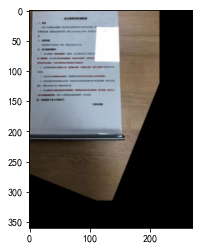

In [6]:
# 平移
# 求出box的在旋转后图像中的坐标，确定平移矩阵
point_rotated = np.dot(MatRotation, np.array([[box[top_left_vertex_idx][0]],[box[top_left_vertex_idx][1]],[1]]))
print(point_rotated)
MatTranslation = np.eye(2)
MatTranslation = np.c_[MatTranslation, -point_rotated]
MatTranslation
img_translation = cv2.warpAffine(img_rotated, MatTranslation, (img.shape[1], img.shape[0]))
plt.imshow(img_translation)

[[ 26 109]
 [168  52]
 [244 243]
 [102 300]]


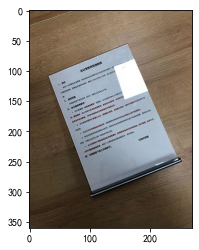

[[ 26. 109.]
 [168.  52.]
 [244. 243.]
 [102. 300.]] [[  0.   0.]
 [270.   0.]
 [270. 360.]
 [  0. 360.]]
[[ 1.63953710e+00 -6.52381255e-01  2.84815922e+01]
 [ 6.52381255e-01  1.62523050e+00 -1.94112037e+02]
 [-9.60070779e-19  1.07092862e-18  1.00000000e+00]]
[[  0.52592593   0.21111111  26.        ]
 [ -0.21111111   0.53055556 109.        ]
 [  0.           0.           1.        ]]
(270, 360)


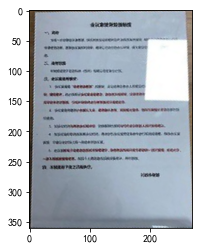

In [7]:

# 根据box的位置做透视变换后铺满整个画面
# 选取四个点，分别是左上、右上、左下、右下
if top_left_vertex_idx == 0:
    vertex_points = box
else:
    vertex_points = []
    for i in range(len(box)):
        vertex_points.append(box[(i+top_left_vertex_idx) % 4])

print(vertex_points)
plt.imshow(img)
plt.show()
# 计算透视变换参数矩阵
def cal_perspective_params(img, points):
    # 设置偏移点。如果设置为(0,0),表示透视结果只显示变换的部分（也就是画框的部分）
    offset_x = 0
    offset_y = 0
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(points)
    # 透视变换的四个点
    dst = np.float32([[offset_x, offset_y], [img_size[0] - offset_x, offset_y],
                      [img_size[0] - offset_x, img_size[1] - offset_y], [offset_x, img_size[1] - offset_y]])

    print(src, dst)
    # 透视矩阵
    M = cv2.getPerspectiveTransform(src, dst)
    print(M)
    # 透视逆矩阵
    M_inverse = cv2.getPerspectiveTransform(dst, src)
    print(M_inverse)
    return M, M_inverse

# 透视变换
def img_perspect_transform(img, M):
    img_size = (img.shape[1], img.shape[0])
    print(img_size)
    return cv2.warpPerspective(img, M, img_size)

M, M_inverse = cal_perspective_params(img, vertex_points)
trasform_img = img_perspect_transform(img, M)
plt.imshow(trasform_img)

[[ 26. 109.]
 [168.  52.]
 [244. 243.]
 [102. 300.]] [[  0.   0.]
 [270.   0.]
 [270. 360.]
 [  0. 360.]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
(3, 3) (3, 3)
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
(3, 3) (3, 3)
(270, 360) [[ 1.6395372e+00 -6.5238130e-01  2.8481602e+01]
 [ 6.5238142e-01  1.6252307e+00 -1.9411206e+02]
 [ 5.1408661e-10  1.6529832e-10  1.0000000e+00]] <class 'numpy.ndarray'>


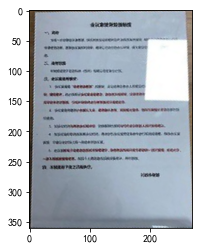

In [8]:
# 自己实现求透视变换矩阵
# 输入是4对坐标点，输出是变换矩阵，求解8个未知数， A * M = B => A.I * A * M = A.I * B => M = A.I * B
# 第2种解法：A * M = B, 调用 cv2.solve(A, B, M) 求解得到M

def my_getPerspectiveTransform(src, dst):
    assert src.shape[0] == dst.shape[0] and src.shape[0] == 4

    A = np.zeros((8, 8)).astype(np.float32)
    M = np.zeros((8, 1)).astype(np.float32)
    B = np.zeros((8, 1)).astype(np.float32)

    for i in range(0, 4):
        A_i = src[i,:]
        B_i = dst[i,:]
        A[2*i, :] = [A_i[0], A_i[1], 1, 0, 0, 0,
                       -A_i[0]*B_i[0], -A_i[1]*B_i[0]]
        B[2*i] = B_i[0]

        A[2*i+1, :] = [0, 0, 0, A_i[0], A_i[1], 1,
                       -A_i[0]*B_i[1], -A_i[1]*B_i[1]]
        B[2*i+1] = B_i[1]

    cv2.solve(A, B, M)  # 求解M, 8个未知量
    M = np.insert(M, 8, 1.0)
    M = M.reshape((3, 3))

    M_ = cv2.getPerspectiveTransform(src, dst)
    print(np.round(M) == np.round(M_))
    print(M.shape, M_.shape)

    return M

# 计算透视变换参数矩阵
def cal_perspective_params2(img, points):
    # 设置偏移点。如果设置为(0,0),表示透视结果只显示变换的部分（也就是画框的部分）
    offset_x = 0
    offset_y = 0
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(points)
    # 透视变换的四个点
    dst = np.float32([[offset_x, offset_y], [img_size[0] - offset_x, offset_y],
                      [img_size[0] - offset_x, img_size[1] - offset_y], [offset_x, img_size[1] - offset_y]])

    print(src, dst)
    # 透视矩阵
    M = my_getPerspectiveTransform(src, dst)
    # 透视逆矩阵
    M_inverse = my_getPerspectiveTransform(dst, src)
    return M, M_inverse

# 透视变换
def img_perspect_transform2(img, M):
    img_size = (img.shape[1], img.shape[0])
    print(img_size, M, type(M))
    return cv2.warpPerspective(img, M, img_size)

M, M_inverse = cal_perspective_params2(img, vertex_points)
trasform_img = img_perspect_transform2(img, M)
plt.imshow(trasform_img)